# Hyper Parameter Tuning for Logistic Regression

Since Logistic Regression preforms the best on our dataset using class_weight = 'balanced', in this notebook we will tune parameters for LR using LogisticRegressionCV and GridSearchCV to see if we can improve our performance

For both methods, we will use a custom scorer - score will be harmonic mean of recall for minority classes and precision of majority class - this is the same metric we have been using to evaluate our models so far

We will compare the results from our Logsitic Regression run from before to see if our performance has improved

Parameters that we will tune for grid search is C (regularization parameter) and max_iter

# Results


Using grid search and Logistic Regression CV yielded similar results. The best parameter for Logistic Regression actually turned out to be the default parameters for C = 1.0 and max_iter = 100



In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import util.model_util as mu
import util.report_util as ru
from datetime import datetime
import logging

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

%matplotlib inline
sns.set()
# If you set this GridSearchCV spews out a bunch of stuff - comment out if you are debugging
# logging.basicConfig(level=logging.ERROR)
# log = logging.getLogger(__name__)

pd.set_option('max_colwidth', 150)


RSTATE=1
N_JOBS=4
CV=5
REPORT_DIR="../reports"
DATASET_DIR="../dataset/feature_files"

# set to True for debug mode
# also you can set the environment variable via command line if using nbconvert
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    BASE = "review_body-tfidf-df_none-ngram22-99-2282-nolda"
    REPORT_FILE_CV = f'{REPORT_DIR}/201911-run_classifiers-50k-lr_cv-report-test.csv'
else:
    BASE = "review_body-tfidf-df_none-ngram13-49784-4000-nolda"
    REPORT_FILE_CV = f'{REPORT_DIR}/201911-run_classifiers-50k-lr_cv-report.csv'

DESCRIPTION = f"{BASE}-nosmote"    
DATA_FILE = f'{DATASET_DIR}/{BASE}.csv'
# we will load our best results from previous training round from this file
REPORT_FILE_LR = f'{REPORT_DIR}/2019-11-01-run_classifiers-50k-report.csv'

/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a fu

In [2]:
data = pd.read_csv(DATA_FILE)

# Prepare our data into training and test sets

In [3]:
??mu.create_training_data

Signature:
mu.create_training_data(
    data: pandas.core.frame.DataFrame,
    class_column: str,
    drop_columns: str = None,
)
Source:   
def create_training_data(data: pd.DataFrame, class_column: str, drop_columns: str = None):
    """
    Make a copy of dataframe and:
    1. split between features and predictions
    2. drop any extra columns
    3. create test and training sets
    :param data: dataframe with data to split
    :param class_column: use this column as labels for training
    :param drop_columns: specify a comma delimited list of strings here if there are any extra columns to be dropped (optional)
    :return: X_train, X_test, y_train, y_test
    """
    # make a copy so we can reuse original DF if need be
    x = data.copy()

    y = x[class_column]
    x.drop(class_column, axis=1, inplace=True)

    if drop_columns:
        drop_list = drop_columns.replace(" ", "").split(",")
        log.info(f"Dropping columns from features {drop_list}")
        x.drop(drop_list,

In [4]:
X_train, X_test, y_train, y_test = mu.create_training_data(data, "star_rating", "helpful_votes, total_votes, helpful_product")

# Use LogisticRegressionCV to find best C parameters for Logistic Regression

But first, lets define our scoring function. Since we want to find the the model that can help us improve minority class recall

In [5]:
from sklearn.linear_model import LogisticRegressionCV
import util.time_util as tu
from sklearn.metrics import make_scorer, classification_report
import numpy as np


def custom_scoring_function_lr_cv(y, y_predict):
    """
    Calculate the harmonic mean of recall for minority classes and precision for majority class
    """
#     print(f'y {y.shape}')
#     print(f'y_predict {y_predict.shape}')
#     print(f'y classes {np.unique(y)}')
    cr = classification_report(y, y_predict, output_dict=True)
#     print(f'cr {cr}')
    
    recall1 = cr["0"]["recall"]
    recall2 = cr["1"]["recall"]
    recall3 = cr["2"]["recall"]
    recall4 = cr["3"]["recall"]
    precision5 = cr["4"]["precision"]
    
    if recall1 > 0 and recall2 > 0 and recall3 > 0 and recall4 > 0 and precision5 > 0:
        score = 5 / (1/recall1 +
                     1/recall2 +
                     1/recall3 +
                     1/recall4 +
                     1/precision5)
    else:
        score = 0
        
    print(f'Scorer score: {score}')
    return score


my_scorer = make_scorer(custom_scoring_function_lr_cv, greater_is_better=True)


lr = LogisticRegressionCV(cv=CV,
                         verbose=1,
                         scoring=my_scorer,
                         class_weight='balanced',
                         multi_class='multinomial',
                          solver="lbfgs",
                         n_jobs=N_JOBS,
                         random_state=RSTATE)

timer = tu.Timer()

timer.start_timer(tu.Keys.TRAIN_TIME_MIN)
lr.fit(X_train, y_train)
timer.end_timer(tu.Keys.TRAIN_TIME_MIN)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.4min finished
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


6.74

# Create a report in the same format as our other runs

In [6]:
def generate_report_df(fit_timer, report_dict):
    """
    Put fit timer and the report_dict from predict into a DataFrame
    :param fit_timer: timer object from fitting our CV
    :param report_dict: report_dict from Model.run()
    :return: dataframe with report info
    """
    report_dict.update(timer.timer_dict)
    report_dict["total_time_min"] = report_dict["train_time_min"] + report_dict["predict_time_min"]
    df = pd.DataFrame(columns=report_dict.keys())
    df = df.append(report_dict, ignore_index=True)
    return df

In [7]:
import importlib
importlib.reload(mu)
model = mu.Model(lr,
              X_train,
              y_train,
              X_test,
              y_test,
              name="LRB_LRCV",
              class_column="star_rating",
              description=DESCRIPTION,
              file=DATA_FILE,
              parameters={
                        "cv": CV,
                        "random_state": RSTATE, 
                        "solver": 'lbfgs',
                        "multi_class": 'multimonial',
                        "class_weight": 'balanced',
                        "n_jobs": N_JOBS,
                        "verbose": 1,
                          "scoring": custom_scoring_function_lr_cv.__name__
                    }
              )
# report_dict has stats and info about our model
report_dict, y_predict = model.run(fit=False)


Since our timer object for training will overwrite the total_time_min. We will re-calculate it again

In [8]:
report_df = generate_report_df(timer, report_dict)
report_df.to_csv(REPORT_FILE_CV, index=False)

# Grid Search

In [9]:
from sklearn.model_selection import RandomizedSearchCV


def custom_scoring_function_gs_cv(y, y_predict):
    """
    Calculate the harmonic mean of recall for minority classes and precision for majority class
    
    For some reason the labeling of classes is different from LogisticRegressionCV to GridSearch. So we have to duplicate the funcation
    """
#     log.info(f'y {y.shape}')
#     log.info(f'y_predict {y_predict.shape}')
#     log.info(f'y classes {np.unique(y)}')
    cr = classification_report(y, y_predict, output_dict=True)
#     log.debug(f'cr {cr}')
    
    recall1 = cr["1"]["recall"]
    recall2 = cr["2"]["recall"]
    recall3 = cr["3"]["recall"]
    recall4 = cr["4"]["recall"]
    precision5 = cr["5"]["precision"]
    
    if recall1 > 0 and recall2 > 0 and recall3 > 0 and recall4 > 0 and precision5 > 0:
        score = 5 / (1/recall1 +
                     1/recall2 +
                     1/recall3 +
                     1/recall4 +
                     1/precision5)
    else:
        score = 0
        
    print(f'Scorer score: {score}')
    return score






lr_grid = LogisticRegression(random_state=RSTATE, 
                        solver='lbfgs',
                        multi_class='auto',
                        class_weight='balanced',
                        n_jobs=N_JOBS,
                        verbose=1)

params = {
    "max_iter": [100, 200, 400, 800],
    "C": [0.001, 0.01, 0.1, 1.0]
         }



my_scorer_grid = make_scorer(custom_scoring_function_gs_cv, greater_is_better=True)

# 5 fold cross validation
cv = GridSearchCV(lr_grid, 
                  cv=CV, 
                  verbose=1, 
                  param_grid=params,
                 scoring=my_scorer_grid)

timer_grid = tu.Timer()
timer_grid.start_timer(tu.Keys.TRAIN_TIME_MIN)
cv.fit(X_train, y_train)
timer_grid.end_timer(tu.Keys.TRAIN_TIME_MIN)


model = mu.Model(cv,
              X_train,
              y_train,
              X_test,
              y_test,
              name="LRB_GSCV",
              class_column="star_rating",
              description=DESCRIPTION,
              file=DATA_FILE,
              parameters={
                        "random_state": RSTATE, 
                        "solver": 'lbfgs',
                        "multi_class": 'auto',
                        "class_weight": 'balanced',
                        "n_jobs": N_JOBS,
                        "verbose": 1,
                          "socring": custom_scoring_function_gs_cv.__name__
                    }
              )
report_dict_grid, y_predict_grid = model.run(fit=False)




Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.3s finished


Scorer score: 0.35066479151183483


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.7s finished


Scorer score: 0.32320922794539714


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.9s finished


Scorer score: 0.34211539386151024


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.8s finished


Scorer score: 0.331593376083387


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.8s finished


Scorer score: 0.3448787932559702


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.8s finished


Scorer score: 0.35066479151183483


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.1s finished


Scorer score: 0.32320922794539714


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.9s finished


Scorer score: 0.34211539386151024


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.7s finished


Scorer score: 0.331593376083387


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.8s finished


Scorer score: 0.3448787932559702


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.9s finished


Scorer score: 0.35066479151183483


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.8s finished


Scorer score: 0.32320922794539714


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.8s finished


Scorer score: 0.34211539386151024


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.8s finished


Scorer score: 0.331593376083387


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.8s finished


Scorer score: 0.3448787932559702


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.7s finished


Scorer score: 0.35066479151183483


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.8s finished


Scorer score: 0.32320922794539714


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.8s finished


Scorer score: 0.34211539386151024


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   10.7s finished


Scorer score: 0.331593376083387


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.6s finished


Scorer score: 0.3448787932559702


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.1s finished


Scorer score: 0.40334060496750207


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.1s finished


Scorer score: 0.3794411017776972


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.3s finished


Scorer score: 0.38734353509243535


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.0s finished


Scorer score: 0.3794063978270404


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.1s finished


Scorer score: 0.39687359319317433


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.1s finished


Scorer score: 0.40334060496750207


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.3s finished


Scorer score: 0.3794411017776972


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.0s finished


Scorer score: 0.38734353509243535


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.1s finished


Scorer score: 0.3794063978270404


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.1s finished


Scorer score: 0.39687359319317433


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.4s finished


Scorer score: 0.40334060496750207


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.0s finished


Scorer score: 0.3794411017776972


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.1s finished


Scorer score: 0.38734353509243535


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.0s finished


Scorer score: 0.3794063978270404


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.5s finished


Scorer score: 0.39687359319317433


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.0s finished


Scorer score: 0.40334060496750207


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.5s finished


Scorer score: 0.3794411017776972


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.4s finished


Scorer score: 0.38734353509243535


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.2s finished


Scorer score: 0.3794063978270404


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.2s finished


Scorer score: 0.39687359319317433


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.6min finished


Scorer score: 0.4704006315789262


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.45151937592980224


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.4558126783850943


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.4452054620548877


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.5min finished


Scorer score: 0.44694255372039987


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.6min finished


Scorer score: 0.4704006315789262


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.45151937592980224


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.4558126783850943


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.4452054620548877


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.6min finished


Scorer score: 0.44694255372039987


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.6min finished


Scorer score: 0.4704006315789262


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.45151937592980224


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.4558126783850943


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.4452054620548877


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.5min finished


Scorer score: 0.44694255372039987


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.6min finished


Scorer score: 0.4704006315789262


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.5min finished


Scorer score: 0.45151937592980224


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.3min finished


Scorer score: 0.4558126783850943


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


Scorer score: 0.4452054620548877


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.6min finished


Scorer score: 0.44694255372039987


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.8min finished


Scorer score: 0.45826070865748264


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.8min finished


Scorer score: 0.45434092834462336


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.9min finished


Scorer score: 0.4584674977593085


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.8min finished


Scorer score: 0.443526681446116


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.8min finished


Scorer score: 0.44151993940224377


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.7min finished


Scorer score: 0.45890770011123905


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.7min finished


Scorer score: 0.45204368586282395


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.7min finished


Scorer score: 0.4594570673442911


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.7min finished


Scorer score: 0.44297987270369354


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.7min finished


Scorer score: 0.4437949558918654


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.4min finished


Scorer score: 0.4591783951805215


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.3min finished


Scorer score: 0.4513899130247686


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.5min finished


Scorer score: 0.4592657673790641


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.5min finished


Scorer score: 0.44297987270369354


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.5min finished


Scorer score: 0.44370855875060866


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.4min finished


Scorer score: 0.4591783951805215


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.4min finished


Scorer score: 0.4513899130247686


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.6min finished


Scorer score: 0.4592657673790641


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.4min finished


Scorer score: 0.44297987270369354


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.4min finished


Scorer score: 0.44370855875060866


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 116.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.3min finished


In [10]:
report_df = report_df.append(generate_report_df(timer_grid, report_dict_grid), ignore_index=True)
report_df.to_csv(REPORT_FILE_CV, index=False)

# Load Our Report so We can analyze results

In [11]:
report_cv = ru.load_report(REPORT_FILE_CV)
report_compare = report_cv.append(ru.load_best_from_report(REPORT_FILE_LR), sort=False).sort_values("model_name")
report_compare

,model_name,description,file,train_examples,train_features,test_examples,test_features,param,model_file,status,...,has_lda,lda_str,has_sampling,sampling_type,label_column,feature_summary,feature_summary_sampling,file_load_time_min,smote_time_min,config_file
0,LRB,review_body-tfidf-df_none-ngram13-49784-4000-nolda-sampling_none-LRB-star_rating,review_body-tfidf-df_none-ngram13-49784-4000-nolda.csv,37338,4000,12446,4000,"{""n_jobs"": 6, ""c"": 1, ""class_weight"": ""balanced"", ""max_iter"": 100, ""verbose"": 1}",../models/review_body-tfidf-df_none-ngram13-49784-4000-nolda-sampling_none-LRB-star_rating.jbl,success,...,False,nolda,False,sampling_none,star_rating,tfidf-ngram13-4000,tfidf-ngram13-sampling_none,0.47,0.0,../config/2019-11-01-run_classifiers-50k.csv
1,LRB_GSCV,review_body-tfidf-df_none-ngram13-49784-4000-nolda-nosmote-LRB_GSCV-star_rating,../dataset/feature_files/review_body-tfidf-df_none-ngram13-49784-4000-nolda.csv,37338,4000,12446,4000,"{""random_state"": 1, ""solver"": ""lbfgs"", ""multi_class"": ""auto"", ""class_weight"": ""balanced"", ""n_jobs"": 4, ""verbose"": 1, ""socring"": ""custom_scoring_fu...",../models/review_body-tfidf-df_none-ngram13-49784-4000-nolda-nosmote-LRB_GSCV-star_rating.jbl,success,...,False,nolda,True,nosmote,star_rating,tfidf-ngram13-4000,tfidf-ngram13-nosmote,NaN,NaN,NaN
0,LRB_LRCV,review_body-tfidf-df_none-ngram13-49784-4000-nolda-nosmote-LRB_LRCV-star_rating,../dataset/feature_files/review_body-tfidf-df_none-ngram13-49784-4000-nolda.csv,37338,4000,12446,4000,"{""cv"": 5, ""random_state"": 1, ""solver"": ""lbfgs"", ""multi_class"": ""multimonial"", ""class_weight"": ""balanced"", ""n_jobs"": 4, ""verbose"": 1, ""scoring"": ""c...",../models/review_body-tfidf-df_none-ngram13-49784-4000-nolda-nosmote-LRB_LRCV-star_rating.jbl,success,...,False,nolda,True,nosmote,star_rating,tfidf-ngram13-4000,tfidf-ngram13-nosmote,NaN,NaN,NaN


# Grid Search Gave us Slightly Higher Performance Than LogisticRegressionCV

Although improvement is ~.005 which is probably not statistically significant

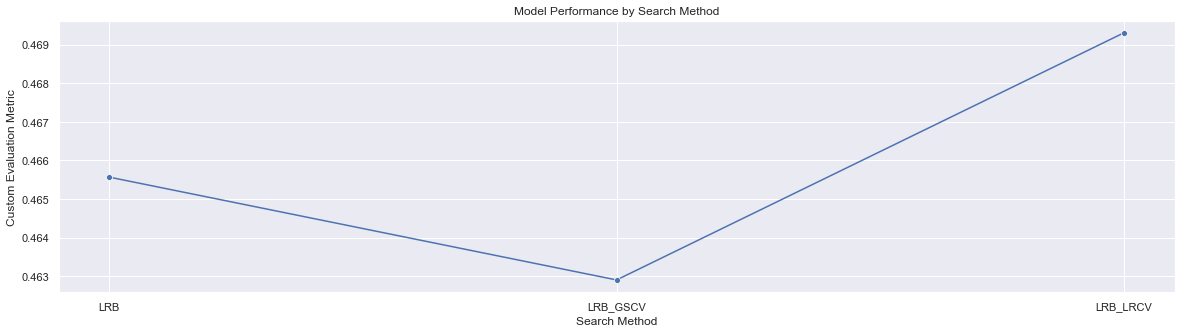

In [12]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

sns.lineplot(data=report_compare, x="model_name", y="eval_metric", marker="o", sort=True)
_ = plt.title("Model Performance by Search Method")
_ = plt.xlabel("Search Method")
_ = plt.ylabel("Custom Evaluation Metric")

### F1 Score, Precision, and Recall Are Roughly The Same

In [13]:
report_compare[ru.EVAL_COLS]

,1_recall,2_recall,3_recall,4_recall,5_precision
0,0.653602,0.347395,0.354756,0.426534,0.856404
1,0.658790,0.349876,0.349614,0.418450,0.850923
0,0.661095,0.348635,0.358183,0.431764,0.858301


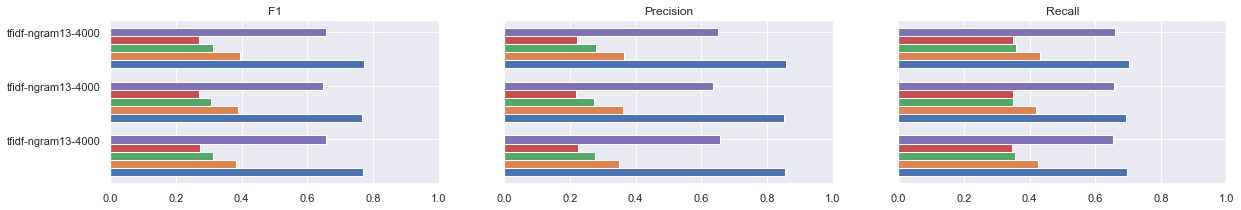

In [14]:
import util.plot_util as pu

pu.plot_score_histograms(report_compare, version=2)

# Grid Search Results

Our best parameters actually came from the default values for Logistic Regression

* Number of iterations did not have an effect on our model
* Increasing C improves performance slightly

In [15]:
cv.best_params_

{'C': 0.1, 'max_iter': 100}

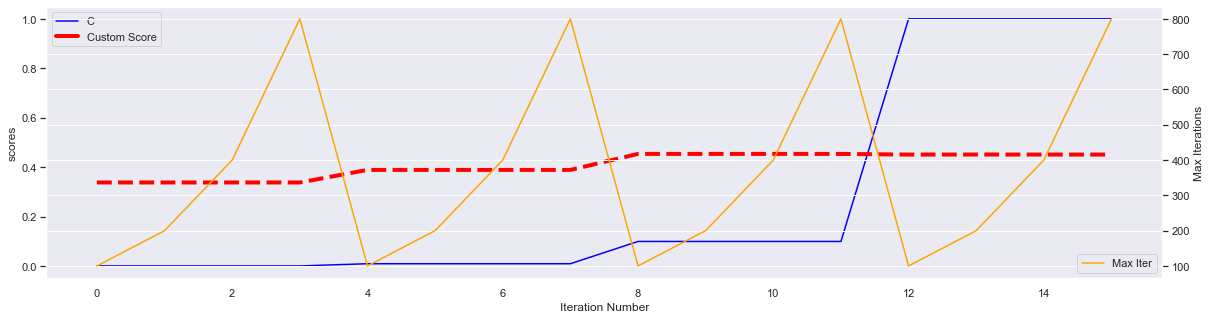

In [18]:
grid_params = pd.DataFrame(cv.cv_results_["params"])
grid_params = pd.concat([grid_params, pd.DataFrame(cv.cv_results_["mean_test_score"]).rename({0:"scores"}, axis=1)], axis=1)

f, a = plt.subplots(1, 1, figsize=(20, 5))

a.grid(False)
sns.lineplot(data=grid_params, x=np.arange(0, len(grid_params)), y="C", label="C", ax=a, color="blue", sort=False)
sns.lineplot(data=grid_params, x=np.arange(0, len(grid_params)), y="scores", label="Custom Score", ax=a, color="red", linewidth=4, sort=False)
a.lines[1].set_linestyle("--")


a2 = a.twinx()
sns.lineplot(data=grid_params, x=np.arange(0, len(grid_params)), y="max_iter", label="Max Iter", ax=a2, color="orange", sort=False)
a2.set_ylabel("Max Iterations")
a2.legend(loc='lower right')



_ = a.set_xlabel("Iteration Number")


In [17]:
grid_params.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
C,0.001000,0.001000,0.001000,0.001000,0.010000,0.010000,0.010000,0.010000,0.100000,0.100000,0.100000,0.100000,1.000000,1.000000,1.000000,1.000000
max_iter,100.000000,200.000000,400.000000,800.000000,100.000000,200.000000,400.000000,800.000000,100.000000,200.000000,400.000000,800.000000,100.000000,200.000000,400.000000,800.000000
scores,0.338492,0.338492,0.338492,0.338492,0.389281,0.389281,0.389281,0.389281,0.453976,0.453976,0.453976,0.453976,0.451223,0.451437,0.451305,0.451305


In [3]:
print(f'Last executed: {datetime.now()}')

Last executed: 2020-01-25 13:09:16.060071
